### Dataset

In [3]:
#Get dataset
import kagglehub

# Download latest version
path = kagglehub.dataset_download("henningheyen/lvis-fruits-and-vegetables-dataset")

print("Path to dataset files:", path)

#Convert from YOLO to COCO format manually by using:
#https://github.com/Taeyoung96/Yolo-to-COCO-format-converter

 26%|██▌       | 359M/1.34G [00:07<00:21, 48.6MB/s] 


KeyboardInterrupt: 

### Model

In [1]:
# Load model directly
from transformers import AutoImageProcessor, AutoModelForObjectDetection

processor = AutoImageProcessor.from_pretrained("facebook/detr-resnet-101")
model = AutoModelForObjectDetection.from_pretrained("facebook/detr-resnet-101")

2025-04-14 05:02:12.598444: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-04-14 05:02:12.619337: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744621332.637898  837813 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744621332.643701  837813 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1744621332.662306  837813 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

### Preprocessing

In [7]:
import numpy as np
from pycocotools.coco import COCO
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import torch
from albumentations.pytorch import ToTensorV2
import albumentations as A

class COCODataset(Dataset):
    def __init__(self, annotation_file, image_dir, processor):
        self.coco = COCO(annotation_file)
        self.image_dir = image_dir
        self.processor = processor
        self.image_ids = list(self.coco.imgs.keys())
        self.final_size = (800, 800)  # Consistent image size for DETR

        # Define basic preprocessing (resize and normalize)
        self.preprocessing = A.Compose([
            A.Resize(height=self.final_size[0], width=self.final_size[1]),
            A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
            ToTensorV2(),
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        image_info = self.coco.loadImgs(image_id)[0]
        image_path = f"{self.image_dir}/{image_info['file_name']}"
        image = Image.open(image_path).convert("RGB")

        # Get annotations
        ann_ids = self.coco.getAnnIds(imgIds=image_id)
        anns = self.coco.loadAnns(ann_ids)

        # Extract bounding boxes and labels
        boxes = [ann['bbox'] for ann in anns]  # [x, y, width, height] COCO format
        labels = [int(ann['category_id']) for ann in anns]

        # Convert COCO format boxes to Pascal VOC format [x_min, y_min, x_max, y_max]
        pascal_boxes = [[x, y, x + w, y + h] for x, y, w, h in boxes]

        # Apply preprocessing
        image = np.array(image)
        transformed = self.preprocessing(image=image, bboxes=pascal_boxes, class_labels=labels)
        image = transformed["image"]
        boxes = torch.tensor(transformed["bboxes"], dtype=torch.float32)
        labels = torch.tensor(transformed["class_labels"], dtype=torch.long)

        # Prepare inputs for DETR
        encoding = {
            "pixel_values": image,
            "labels": labels,
            "boxes": boxes,
        }
        return encoding

In [8]:
def collate_fn(batch):
    """
    Custom collate function to handle batches with different numbers of annotations.
    """
    # Stack pixel_values - ensuring it has the right shape [batch_size, channels, height, width]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    # Collect boxes and labels as lists since they may have different lengths
    boxes = [item["boxes"] for item in batch]
    labels = [item["labels"] for item in batch]

    # Return a dictionary with the expected DETR input format
    return {
        "pixel_values": pixel_values,
        "boxes": boxes,
        "labels": labels,
    }

# Create data pipeline/dataloader with custom collate_fn
annotation_file = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/annotations/train.json'
image_dir = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/images/train'
dataset = COCODataset(annotation_file, image_dir, processor)
dataloader = DataLoader(dataset, batch_size=3, shuffle=True, collate_fn=collate_fn)

# Create validation dataset
val_annotation_file = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/annotations/val.json'
val_image_dir = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/images/val'
val_dataset = COCODataset(val_annotation_file, val_image_dir, processor)
val_dataloader = DataLoader(val_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)

# Create test dataset
test_annotation_file = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/annotations/test.json'
test_image_dir = '/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/images/test'
test_dataset = COCODataset(test_annotation_file, test_image_dir, processor)
test_dataloader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=collate_fn)


loading annotations into memory...
Done (t=1.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


### Training

### Freeze Early Backbone

In [9]:
# Get the number of classes in your dataset
num_classes = len(dataset.coco.getCatIds())  # Assuming `dataset` is your training dataset

# Freeze the main layers of the backbone
for name, param in model.named_parameters():
    if "backbone" in name and "layer4" not in name:  # Keep the final layer (layer4) trainable
        param.requires_grad = False
    else:
        param.requires_grad = True

# Update the output layer to match the number of classes
from torch import nn

# Replace the classification head
model.class_labels_classifier = nn.Linear(
    model.class_labels_classifier.in_features, num_classes + 1  # +1 for the "no object" class
)

# Verify the changes
print("Updated model:")
print(model)

# Count trainable parameters
def count_parameters(model):
    trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
    total = sum(p.numel() for p in model.parameters())
    print(f"Trainable parameters: {trainable:,} ({trainable/total:.2%} of total {total:,})")

count_parameters(model)

Updated model:
DetrForObjectDetection(
  (model): DetrModel(
    (backbone): DetrConvModel(
      (conv_encoder): DetrConvEncoder(
        (model): FeatureListNet(
          (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
          (bn1): DetrFrozenBatchNorm2d()
          (act1): ReLU(inplace=True)
          (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
          (layer1): Sequential(
            (0): Bottleneck(
              (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
              (bn1): DetrFrozenBatchNorm2d()
              (act1): ReLU(inplace=True)
              (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
              (bn2): DetrFrozenBatchNorm2d()
              (drop_block): Identity()
              (act2): ReLU(inplace=True)
              (aa): Identity()
              (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bia

### Run Epochs

In [12]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.notebook import tqdm

print("Logits shape:", outputs.logits.shape)  # [batch_size, num_queries, num_classes]
print("Empty weight shape:", empty_weight.shape)
print("Expected num_classes + 1:", num_classes + 1)

NameError: name 'outputs' is not defined

In [ ]:
import torch
from torch.optim import AdamW
from transformers import get_scheduler
from tqdm.notebook import tqdm

def reinitialize_detr_model(model, num_classes, device):
    """
    Properly reinitialize DETR model with correct number of classes
    and fix the weight tensor error in ImageLoss.
    """
    from torch import nn
    import torch
    from transformers.models.detr.modeling_detr import DetrForObjectDetection
    
    print(f"Reinitializing model for {num_classes} classes...")
    
    # 1. Replace the classification head
    model.class_labels_classifier = nn.Linear(
        model.class_labels_classifier.in_features, 
        num_classes + 1  # +1 for the "no object" class
    )
    
    # 2. Update model config
    model.config.num_labels = num_classes + 1
    
    # 3. Find all modules with empty_weight and update them
    print("Searching for modules with empty_weight...")
    count = 0
    for name, module in model.named_modules():
        if hasattr(module, 'empty_weight'):
            count += 1
            print(f"Updating module {count}: {name}")
            # Create new empty_weight with correct size
            empty_weight = torch.ones(num_classes + 1, device=device)
            empty_weight[-1] = 0.1  # Lower weight for background class
            module.empty_weight = empty_weight
            module.num_classes = num_classes
    
    # 4. Move model to device
    model = model.to(device)
    
    # 5. Handle the case where we need to patch during forward pass
    if count == 0:
        print("No modules with empty_weight found, using workaround in training loop")
        print("Add this code at the start of each forward pass in your training loop:")
        print("""
        # Create empty_weight tensor for loss calculation
        empty_weight = torch.ones(num_classes + 1, device=device)
        empty_weight[-1] = 0.1  # Lower weight for background class
        
        # Add this to your batch processing loop
        with patch_empty_weight(model, empty_weight, num_classes):
            outputs = model(pixel_values=pixel_values, labels=targets)
        """)
    
    print(f"Model reinitialization complete. Fixed {count} modules with empty_weight.")
    return model

# Create a context manager to temporarily patch the model's loss function
class patch_empty_weight:
    """Context manager to temporarily patch a DETR model's empty_weight tensor during forward pass."""
    
    def __init__(self, model, empty_weight, num_classes):
        self.model = model
        self.empty_weight = empty_weight
        self.num_classes = num_classes
        self.modified_modules = []
        
    def __enter__(self):
        # Find all modules with empty_weight and store original values
        for name, module in self.model.named_modules():
            if hasattr(module, 'empty_weight'):
                # Save original values
                self.modified_modules.append((
                    module,
                    getattr(module, 'empty_weight', None),
                    getattr(module, 'num_classes', None)
                ))
                # Update with new values
                module.empty_weight = self.empty_weight
                module.num_classes = self.num_classes
        return self
        
    def __exit__(self, exc_type, exc_val, exc_tb):
        # Restore original values
        for module, orig_empty_weight, orig_num_classes in self.modified_modules:
            if orig_empty_weight is not None:
                module.empty_weight = orig_empty_weight
            if orig_num_classes is not None:
                module.num_classes = orig_num_classes
                
# Setup device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

num_classes = len(dataset.coco.getCatIds())

# Create empty_weight tensor for loss calculation
empty_weight = torch.ones(num_classes + 1, device=device)
empty_weight[-1] = 0.1  # Lower weight for background class

# Reinitialize model with correct class count
model = reinitialize_detr_model(model, num_classes, device)

# Set up optimizer and scheduler
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-5, weight_decay=1e-4)
num_epochs = 20
num_training_steps = len(dataloader) * num_epochs
lr_scheduler = get_scheduler("linear", optimizer=optimizer, num_warmup_steps=100, num_training_steps=num_training_steps)

# Training and validation loop
best_val_loss = float('inf')
best_model_path = "best_detr_model"

print("Starting training...")
for epoch in range(num_epochs):
    # Training phase
    model.train()
    total_train_loss = 0
    train_batch_count = 0

    print(f"Epoch {epoch + 1}/{num_epochs} - Training:")
    train_loop = tqdm(dataloader, leave=True)

    for batch in train_loop:
        # Move pixel_values to device
        pixel_values = batch["pixel_values"].to(device)

        # Create targets list in the format DETR expects
        targets = []
        for img_idx in range(len(batch["labels"])):
            targets.append({
                "class_labels": batch["labels"][img_idx].to(device),
                "boxes": batch["boxes"][img_idx].to(device)
            })

        # Forward pass with context manager to ensure correct empty_weight
        with patch_empty_weight(model, empty_weight, num_classes):
            outputs = model(pixel_values=pixel_values, labels=targets)
            
        loss = outputs.loss
        total_train_loss += loss.item()
        train_batch_count += 1

        # Update progress bar
        train_loop.set_postfix(loss=loss.item())

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lr_scheduler.step()

    avg_train_loss = total_train_loss / train_batch_count if train_batch_count > 0 else 0

    # Validation phase
    model.eval()
    total_val_loss = 0
    val_batch_count = 0

    print(f"Epoch {epoch + 1}/{num_epochs} - Validation:")
    val_loop = tqdm(val_dataloader, leave=True)
    with torch.no_grad():
        for batch in val_loop:
            # Move pixel_values to device
            pixel_values = batch["pixel_values"].to(device)

            # Create targets list
            targets = []
            for img_idx in range(len(batch["labels"])):
                targets.append({
                    "class_labels": batch["labels"][img_idx].to(device),
                    "boxes": batch["boxes"][img_idx].to(device)
                })

            # Forward pass with context manager to ensure correct empty_weight
            with patch_empty_weight(model, empty_weight, num_classes):
                outputs = model(pixel_values=pixel_values, labels=targets)
                
            loss = outputs.loss
            total_val_loss += loss.item()
            val_batch_count += 1

            # Update progress bar
            val_loop.set_postfix(loss=loss.item())

    avg_val_loss = total_val_loss / val_batch_count if val_batch_count > 0 else 0

    print(f"Epoch {epoch + 1} - Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}")

    # Save best model based on validation loss
    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        model.save_pretrained(best_model_path)
        processor.save_pretrained(best_model_path)
        print(f"Saved new best model to {best_model_path}")

Using device: cuda
Reinitializing model for 63 classes...
Searching for modules with empty_weight...
No modules with empty_weight found, using workaround in training loop
Add this code at the start of each forward pass in your training loop:

        # Create empty_weight tensor for loss calculation
        empty_weight = torch.ones(num_classes + 1, device=device)
        empty_weight[-1] = 0.1  # Lower weight for background class
        
        # Add this to your batch processing loop
        with patch_empty_weight(model, empty_weight, num_classes):
            outputs = model(pixel_values=pixel_values, labels=targets)
        
Model reinitialization complete. Fixed 0 modules with empty_weight.
Starting training...
Epoch 1/20 - Training:


  0%|          | 0/2241 [00:00<?, ?it/s]

RuntimeError: weight tensor should be defined either for all or no classes

### Testing

In [ ]:
# Function to calculate mAP and other metrics
def calculate_metrics(predictions, targets, iou_threshold=0.5):
    """
    Calculate precision, recall, and mAP
    This is a simplified version - consider using proper COCO evaluation tools for production
    """
    # Simplified metric calculation
    correct_detections = 0
    total_predictions = 0
    total_ground_truth = 0
    
    for pred, target in zip(predictions, targets):
        # Your metric calculation code here
        # This is just a placeholder
        pass
    
    precision = correct_detections / total_predictions if total_predictions > 0 else 0
    recall = correct_detections / total_ground_truth if total_ground_truth > 0 else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0
    
    return {"precision": precision, "recall": recall, "f1": f1}

# Load best model for testing
best_model = AutoModelForObjectDetection.from_pretrained(best_model_path)
best_model.to(device)

# Evaluation on test set
best_model.eval()
test_predictions = []
test_targets = []

print("Evaluating on test set:")
test_loop = tqdm(test_dataloader, leave=True)
with torch.no_grad():
    for batch in test_loop:
        # Move pixel_values to device
        pixel_values = batch["pixel_values"].to(device)
        
        # Store targets for evaluation
        targets = []
        for img_idx in range(len(batch["labels"])):
            targets.append({
                "labels": batch["labels"][img_idx],
                "boxes": batch["boxes"][img_idx]
            })
        test_targets.extend(targets)
        
        # Get predictions
        outputs = best_model(pixel_values=pixel_values)
        
        # Process outputs to get predictions
        for i, output in enumerate(outputs.logits):
            scores = torch.softmax(output, dim=-1)
            # Get top predictions
            scores, labels = torch.max(scores, dim=-1)
            boxes = outputs.pred_boxes[i]
            
            # Filter predictions by confidence threshold
            keep = scores > 0.5
            predictions = {
                "scores": scores[keep].cpu().numpy(),
                "labels": labels[keep].cpu().numpy(),
                "boxes": boxes[keep].cpu().numpy()
            }
            test_predictions.append(predictions)

# Calculate and print metrics
metrics = calculate_metrics(test_predictions, test_targets)
print(f"Test Metrics: {metrics}")

### Evaluation and Visualization

In [ ]:
# Function to visualize predictions
def visualize_predictions(model, dataloader, num_images=3):
    """Visualize predictions from model on sample images"""
    import matplotlib.pyplot as plt
    import matplotlib.patches as patches
    import random
    import numpy as np
    
    # Get category names from your dataset
    coco = COCO('/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/annotations/test.json')
    categories = coco.loadCats(coco.getCatIds())
    cat_id_to_name = {cat['id']: cat['name'] for cat in categories}
    
    model.eval()
    all_images = []
    all_outputs = []
    all_targets = []
    
    # Collect some sample images
    with torch.no_grad():
        for batch in dataloader:
            pixel_values = batch["pixel_values"].to(device)
            all_images.append(pixel_values.cpu())
            
            # Store ground truth
            batch_targets = []
            for img_idx in range(len(batch["labels"])):
                batch_targets.append({
                    "labels": batch["labels"][img_idx],
                    "boxes": batch["boxes"][img_idx]
                })
            all_targets.extend(batch_targets)
            
            # Get predictions
            outputs = model(pixel_values=pixel_values)
            all_outputs.append(outputs)
            
            if len(all_images) * batch["pixel_values"].shape[0] >= num_images:
                break
    
    # Flatten image list
    flat_images = [img for batch_imgs in all_images for img in batch_imgs]
    
    # Select random images
    indices = random.sample(range(len(flat_images)), min(num_images, len(flat_images)))
    
    # Plot the selected images
    fig, axes = plt.subplots(len(indices), 2, figsize=(12, 5*len(indices)))
    
    for i, idx in enumerate(indices):
        # Get the image
        img = flat_images[idx].permute(1, 2, 0).numpy()
        img = (img - img.min()) / (img.max() - img.min())  # Normalize for display
        
        # Plot ground truth
        axes[i, 0].imshow(img)
        axes[i, 0].set_title("Ground Truth")
        
        for box, label in zip(all_targets[idx]["boxes"], all_targets[idx]["labels"]):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='g', facecolor='none')
            axes[i, 0].add_patch(rect)
            
            # Add label
            cat_name = cat_id_to_name.get(label, f"Class {label}")
            axes[i, 0].text(x1, y1-5, cat_name, color='white', fontsize=10, bbox=dict(facecolor='green', alpha=0.7))
        
        # Plot predictions
        axes[i, 1].imshow(img)
        axes[i, 1].set_title("Predictions")
        
        # Get the corresponding batch and index within batch
        batch_idx = idx // dataloader.batch_size
        img_idx_in_batch = idx % dataloader.batch_size
        
        # Get predictions
        logits = all_outputs[batch_idx].logits[img_idx_in_batch]
        boxes = all_outputs[batch_idx].pred_boxes[img_idx_in_batch]
        
        # Convert logits to probabilities
        probs = torch.softmax(logits, dim=-1)
        # Get highest probability and corresponding label
        scores, pred_labels = torch.max(probs, dim=-1)
        
        # Filter by confidence threshold
        keep = scores > 0.5
        filtered_boxes = boxes[keep].cpu().numpy()
        filtered_labels = pred_labels[keep].cpu().numpy()
        filtered_scores = scores[keep].cpu().numpy()
        
        for box, label, score in zip(filtered_boxes, filtered_labels, filtered_scores):
            x1, y1, x2, y2 = box
            w, h = x2 - x1, y2 - y1
            rect = patches.Rectangle((x1, y1), w, h, linewidth=2, edgecolor='r', facecolor='none')
            axes[i, 1].add_patch(rect)
            
            # Add label with confidence score
            cat_name = cat_id_to_name.get(label, f"Class {label}")
            axes[i, 1].text(x1, y1-5, f"{cat_name} {score:.2f}", color='white', fontsize=10, 
                         bbox=dict(facecolor='red', alpha=0.7))
        
        axes[i, 0].axis('off')
        axes[i, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize predictions on test set
visualize_predictions(best_model, test_dataloader, num_images=3)

In [ ]:
# Save the final model if needed
final_model_path = "final_detr_food_model"
model.save_pretrained(final_model_path)
processor.save_pretrained(final_model_path)
print(f"Final model saved to {final_model_path}")

### Verify COCO Format

COCO Dataset Structure Verification:
- Number of categories: 63
- Number of images: 1500
- Number of annotations: 33695


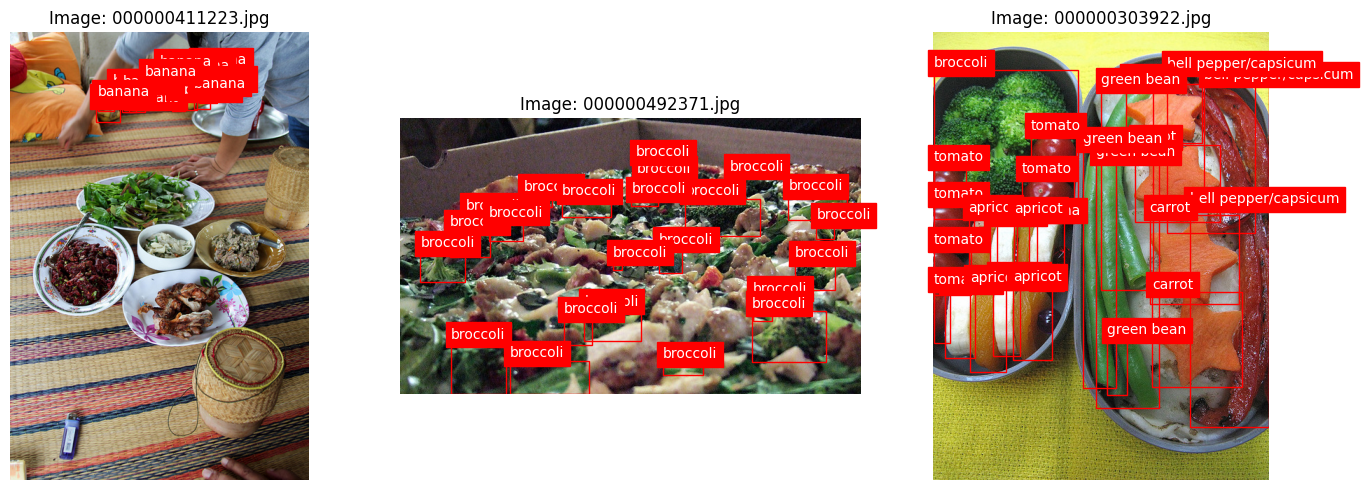

Visualization complete - verify that bounding boxes match objects in images


In [5]:
import json
import os
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import random
import numpy as np

#Image subdirectories
subset = 'val' #replace this value with whichever subdirectory you want to test ex. 'train', 'test'

# Load COCO annotations
coco_dir = 'LVIS_Fruits_And_Vegetables/COCO-format'
coco_json_path = os.path.join(coco_dir, 'annotations', f'{subset}.json')
with open(coco_json_path, 'r') as f:
    coco_data = json.load(f)

# 1. Check dataset structure
print("COCO Dataset Structure Verification:")
print(f"- Number of categories: {len(coco_data.get('categories', []))}")
print(f"- Number of images: {len(coco_data.get('images', []))}")
print(f"- Number of annotations: {len(coco_data.get('annotations', []))}")

# 2. Check required fields
required_fields = ['images', 'annotations', 'categories']
for field in required_fields:
    if field not in coco_data:
        print(f"ERROR: Required field '{field}' is missing!")

# 3. Check consistency between images and annotations
image_ids = set(img['id'] for img in coco_data['images'])
ann_image_ids = set(ann['image_id'] for ann in coco_data['annotations'])
orphaned_annotations = ann_image_ids - image_ids
if orphaned_annotations:
    print(f"WARNING: Found {len(orphaned_annotations)} annotations with no corresponding images")

category_ids = set(cat['id'] for cat in coco_data['categories'])
ann_category_ids = set(ann['category_id'] for ann in coco_data['annotations'])
invalid_categories = ann_category_ids - category_ids
if invalid_categories:
    print(f"WARNING: Found annotations with invalid category IDs: {invalid_categories}")

# 4. Create a category ID to name mapping
cat_id_to_name = {cat['id']: cat['name'] for cat in coco_data['categories']}

# 5. Visualize random samples to verify annotations
def visualize_coco_sample(coco_data, img_dir, num_samples=3):
    # Select random images
    sample_images = random.sample(coco_data['images'], min(num_samples, len(coco_data['images'])))
    
    fig, axes = plt.subplots(1, num_samples, figsize=(5*num_samples, 5))
    if num_samples == 1:
        axes = [axes]
    
    for i, img_info in enumerate(sample_images):
        # Load image
        img_path = os.path.join(img_dir, img_info['file_name'])
        img = Image.open(img_path)
        axes[i].imshow(np.array(img))
        
        # Get annotations for this image
        img_anns = [ann for ann in coco_data['annotations'] if ann['image_id'] == img_info['id']]
        
        # Draw bounding boxes
        for ann in img_anns:
            bbox = ann['bbox']  # [x, y, width, height]
            category_name = cat_id_to_name.get(ann['category_id'], f"Unknown ({ann['category_id']})")
            
            # Create rectangle patch
            rect = patches.Rectangle(
                (bbox[0], bbox[1]), bbox[2], bbox[3],
                linewidth=1, edgecolor='r', facecolor='none'
            )
            axes[i].add_patch(rect)
            
            # Add label
            axes[i].text(
                bbox[0], bbox[1] - 5, category_name,
                color='white', fontsize=10, backgroundcolor='red'
            )
        
        axes[i].set_title(f"Image: {img_info['file_name']}")
        axes[i].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images with annotations
try:
    img_dir = os.path.join(coco_dir, f'images/{subset}')
    visualize_coco_sample(coco_data, img_dir, num_samples=3)
    print("Visualization complete - verify that bounding boxes match objects in images")
except Exception as e:
    print(f"Error visualizing samples: {e}")

In [17]:
#Another method for verification

from pycocotools.coco import COCO

coco = COCO('/home/tommytang111/Projects/Food Recognition/LVIS_Fruits_And_Vegetables/COCO-format/annotations/train.json')
coco.loadImgs(1)  # Load image with ID 1


loading annotations into memory...
Done (t=0.72s)
creating index...
index created!


[{'file_name': '000000000196.jpg', 'height': 480, 'width': 640, 'id': 1}]